In [184]:
#update libs
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade pprint
!pip install --upgrade hyperopt
!pip install --upgrade hpsklearn
!pip install --upgrade seaborn

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.23.4)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: hyperopt in c:\anaconda\lib\site-packages (0.1.1)
Requirement already up-to-date: hpsklearn in c:\anaconda\lib\site-packages (0.1.0)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)


In [185]:
#import common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

#from scipy import interp
sns.set(font_scale=1.3)

In [50]:
#import special libs

from sklearn.preprocessing import label_binarize,MultiLabelBinarizer
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from itertools import cycle

from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, recall_score, brier_score_loss, roc_curve, auc
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, precision_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD,IncrementalPCA

import glob

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.calibration import CalibratedClassifierCV, calibration_curve


%matplotlib inline

In [51]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

import re
import string
import inflect
from pprint import pprint
from tqdm import tqdm

from sklearn.datasets import fetch_20newsgroups
seed = 321

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


Загрузим датасет с классифицируемыми текстами.

In [265]:
# здесь shuffle = true, т.к. мы собираемся использовать SGDClassifier; Naive Bayes - они базируются на принципе iid данных 
#и чтобы не получить смещенную оценку
newsgroups_all = fetch_20newsgroups(subset='all', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

Итак, задача данной работы:



#### EDA.

Посмотрим на данные, для этого:
- посмотрим на категории текстов
- распределение документов по категориям
- посмотрим на примеры данных

In [266]:
pprint("%d documents" % len(newsgroups_all.data))
pprint("%d categories" % len(newsgroups_all.target_names))

'18846 documents'
'20 categories'


In [270]:
def generate_stat_df(df,df_type):
    unique, counts = np.unique(df.target, return_counts=True)

    df_print = pd.DataFrame(data=list(zip(unique, df.target_names, counts)), 
                            columns = ['Id_category', 'Category_Name', 'N_texts'])
    df_print['High_level_topic'] = df_print["Category_Name"].str.split(".", expand = True)[0]
    df_print['Dataset_Type'] = df_type
    return df_print

df_summary = generate_stat_df(train_texts, 'train')
df_summary = df_summary.append(generate_stat_df(test_texts, 'test'), ignore_index=True)
df_summary = df_summary.append(generate_stat_df(newsgroups_all, 'all'), ignore_index=True)

,Id_category,Category_Name,N_texts,High_level_topic,Dataset_Type
0,0,alt.atheism,480,alt,train
1,1,comp.graphics,584,comp,train
2,2,comp.os.ms-windows.misc,591,comp,train
3,3,comp.sys.ibm.pc.hardware,590,comp,train
4,4,comp.sys.mac.hardware,578,comp,train
5,5,comp.windows.x,593,comp,train
6,6,misc.forsale,585,misc,train
7,7,rec.autos,594,rec,train
8,8,rec.motorcycles,598,rec,train
9,9,rec.sport.baseball,597,rec,train


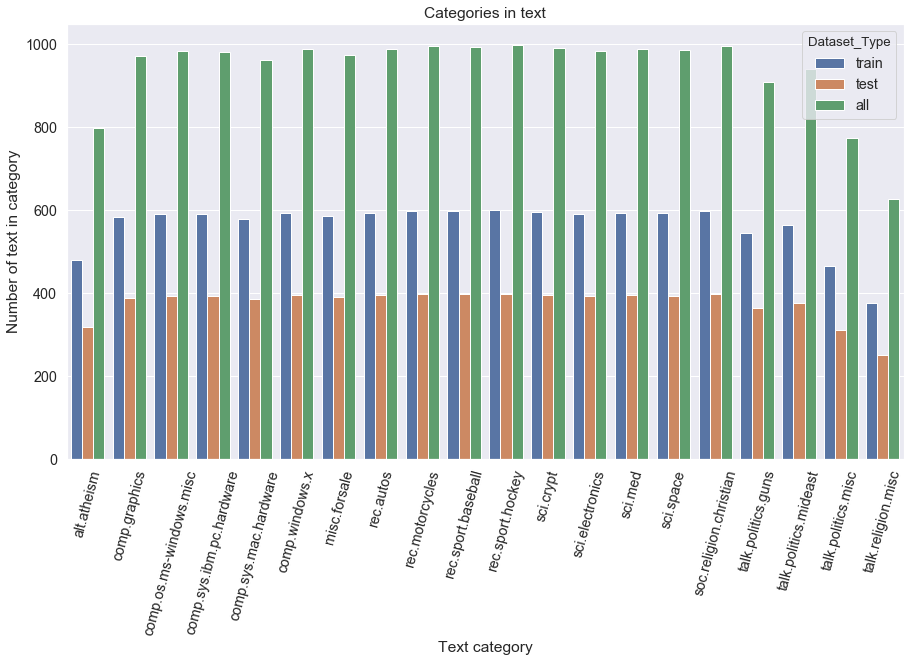

In [271]:
# print the histogramm with distribution of texts by categorieas and topics
plt.figure(figsize=(15,8))
sns.barplot(x="Category_Name", y="N_texts", hue = 'Dataset_Type',data=df_summary)
plt.xticks(rotation=75)
plt.xlabel('Text category');
plt.ylabel('Number of text in category');
plt.title("Categories in text");

                   0     1      2     3     4      5     6     7      8   \
High_level_topic  alt   alt    alt  comp  comp   comp  misc  misc   misc   
Dataset_Type      all  test  train   all  test  train   all  test  train   
N_texts           799   319    480  4891  1955   2936   975   390    585   

                    9   ...       11    12    13     14   15    16     17  \
High_level_topic   rec  ...      rec   sci   sci    sci  soc   soc    soc   
Dataset_Type       all  ...    train   all  test  train  all  test  train   
N_texts           3979  ...     2389  3952  1579   2373  997   398    599   

                    18    19     20  
High_level_topic  talk  talk   talk  
Dataset_Type       all  test  train  
N_texts           3253  1301   1952  

[3 rows x 21 columns]


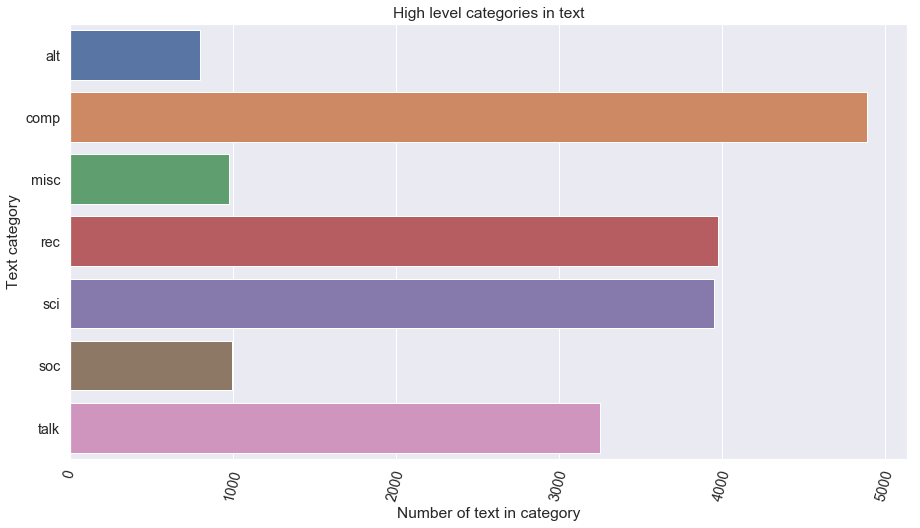

In [316]:
groupped_df = df_summary.groupby(['High_level_topic','Dataset_Type']).agg({'N_texts': ['sum']})
groupped_df.columns = groupped_df.columns.droplevel(1)
groupped_df.reset_index(inplace=True)
print(groupped_df.T)


plt.figure(figsize=(15,8))
sns.barplot(x="N_texts", y="High_level_topic", data=groupped_df[groupped_df.Dataset_Type == 'all'])
plt.xticks(rotation=75)
plt.xlabel('Number of text in category');
plt.ylabel('Text category');
plt.title("High level categories in text");

Посмотрим на образец данных.

In [57]:
pprint(newsgroups_all.data[3])

("You can't call time when there's a play in progress.\n"
 '\n'
 'Ryan Robbins\n'
 'Penobscot Hall\n'
 'University of Maine')


In [58]:
newsgroups_all.target_names[newsgroups_all.target[1]]

'sci.space'

#### Data preprocessing.

Предобработаем данные, для этого:
- приведем все слова к нижнему регистру+.
- удалим знаки препинания+.
- заменим представление чисел в виде цифр на текстовые аналоги+.
- отсечем стоп слова (уберем символы и комбинации, которые не составляют смысловой нагрузки)+.
- проведем лемматизацию/стемминг (приведение слова к начальной форме с помощью словаря/выделение корня слова)+.
- удалим слова длиной 2 и менее символов+.
- выделим n-граммы (последовательности из нескольких слов, рассматриваемых как одно целое).

In [59]:
def remove_punctuation(text_punctuation,text):
    
    new_text = []
    #new_text = re.sub('['+text_punctuation+']', '',text)
    #new_text = re.sub('\n', ' ',new_text)
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.lower()
        new_word =  re.sub('\n', ' ',new_word)
        new_word =  re.sub('\t', ' ',new_word)
        new_word =  re.sub(' +', ' ',new_word)
        new_text.append(new_word)
    
    return new_text

In [60]:
def digits_to_text(text):
    p = inflect.engine()
    new_text = []
    for word in text:
        if word.isdigit():
            if len(word) > 18:
                print (1) #do nothing
            else:
                new_word = p.number_to_words(word)
                new_text.append(new_word)
        else:
            new_text.append(word)
    #del p
    return new_text

In [61]:
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='v') # pay attention to pos='v' parameter!
        new_text_lemma.append(lemma)
        
        stemm = stemmer.stem(word)
        new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

In [62]:
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna']
StopWords.extend(newStopWords)
StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))

StopWords.extend(Common_First_Names)

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

In [63]:
def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text

In [64]:
# getting source from string.punctuation, but removed right slash / and ^
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~'

def tokenize(text):
    min_length = 3
    
    #remove punctuation
    #text = remove_punctuation(text_punctuation, text)    
    
    # tokenize text
    words = word_tokenize(text,language='english')
    
    #remove punctuation and to lowercase
    words = remove_punctuation(text_punctuation, words)   
    
    #replace digits with words
    words = digits_to_text(words)
        
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize or stemm words 
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 3)

    return words

In [65]:
pprint(newsgroups_all.data[1]) #1,3,5

('\n'
 'jfc> If gamma ray bursters are extragalactic, would absorption from the\n'
 'jfc> galaxy be expected?  How transparent is the galactic core to gamma\n'
 'jfc> rays?\n'
 '\n'
 'and later...\n'
 '\n'
 'JB> So, if the 1/r^2 law is incorrect (assume\n'
 'JB> some unknown material [dark matter??] inhibits Gamma Ray propagation),\n'
 'JB> could it be possible that we are actually seeing much less energetic\n'
 'JB> events happening much closer to us?  The even distribution could\n'
 'JB> be caused by the characteristic propagation distance of gamma rays \n'
 'JB> being shorter then 1/2 the thickness of the disk of the galaxy.\n'
 '\n'
 '\n'
 ' 0.\n'
 '\n'
 ' Well, maybe not zero, but very little.  At the typical energies for \n'
 ' gamma rays, the Galaxy is effectively transparent. \n'
 '\n'
 ' Hans Bloemen had a review article in Ann. Rev. Astr. Astrophys. a few \n'
 ' years back in which he discusses this in more depth.')


In [66]:
%%time
test = tokenize(newsgroups_all.data[1])

Wall time: 17.9 ms


In [67]:
test

['gamma',
 'bursters',
 'extragalactic',
 'absorption',
 'galaxy',
 'expect',
 'transparent',
 'galactic',
 'core',
 'gamma',
 'ray',
 'later',
 '1/r^2',
 'law',
 'incorrect',
 'assume',
 'unknown',
 'material',
 'dark',
 'matter',
 'inhibit',
 'gamma',
 'propagation',
 'possible',
 'actually',
 'see',
 'energetic',
 'events',
 'happen',
 'closer',
 'distribution',
 'cause',
 'characteristic',
 'propagation',
 'distance',
 'gamma',
 'ray',
 'shorter',
 '1/2',
 'thickness',
 'disk',
 'galaxy',
 'zero',
 'maybe',
 'zero',
 'little',
 'typical',
 'energies',
 'gamma',
 'ray',
 'galaxy',
 'effectively',
 'transparent',
 'bloemen',
 'review',
 'article',
 'rev',
 'astr',
 'astrophys',
 'years',
 'discuss',
 'depth']

После того, как проверили работу токенизатора, извлечем фичи из текста с использованием TF-IDF.

Выделим для этого метки для трейн/тест датасетов.

In [68]:
y_train, y_test = train_texts.target, test_texts.target

In [69]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             #min_df=0.05, # ignore terms with freq more that 0.05, lower majoring
                             #max_df=0.90, # ignore terms with freq more that 0.9, upper majoring
                             #max_features=3000,
                             use_idf=True,  #need this parameter
                             sublinear_tf=True,
                             norm='l2'                            
                            )

In [70]:
%%time
vectorised_train_documents = vectorizer.fit_transform(train_texts.data)
vectorised_test_documents = vectorizer.transform(test_texts.data)

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [' ll', ' re', ' ve', 'ann mari', 'ann marie', 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 'kara lynn', 'marie ann', 'marie jeanne', 'n t', 'paula grace', 'sara ann', 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 9min 29s


Напишем функцию, которая будет производить:
- извлечение фич.
- вывод результатов работы классификатора.
- производить кросс-валидацию по 5 фолдам.

In [103]:
results_df = []
results_df = pd.DataFrame(columns=('Algorithm', 'Train_score', 'Test_score_cv', 'parameters'))

In [104]:
#variant with pipeline and cv
'''def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    tfidf_params = {
        'stop_words' : StopWords,
        'tokenizer':tokenize,
        'use_idf':True,
        'sublinear_tf':True,
        'norm':'l2'
    }
    clf = Pipeline([('vect', TfidfVectorizer(** tfidf_params)), ('classifier', classifier)])
    
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    #pred_test = clf.predict(X_test)
    #f1_test = f1_score(y_test, pred_test, average='micro')
    
    my_scorer = make_scorer(f1_score, average='weighted')
    skv = StratifiedKFold(n_splits = 3,random_state=seed, shuffle=True)
    f1_test = cross_val_score(clf, X_test, y_test, cv=skv, scoring=my_scorer,n_jobs = -1).mean()
    
    return f1_train, f1_test


alphas = [0.01 , 0.015, 0.02]

for alph in tqdm(alphas):
    a = "MultinomialNB"
    b,c = classify_and_score(MultinomialNB(alpha=alph), train_texts.data, 
                           test_texts.data, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score_cv':c, 'parameters':d},ignore_index=True)
    
    ''';

In [105]:
#simple variant
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='micro')
    
    return f1_train, f1_test

Проверим работу алгоритмов на:
- MultinomialNB
- BernoulliNB

In [ ]:
#actual block of code
alphas = [0.0001,0.001,0.005 ,0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,2,5]

for alph in alphas:
    f_el = "MultinomialNB"
    s_el,t_el = classify_and_score(MultinomialNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

In [344]:
best_params = results_df[results_df.Test_score_cv >=  results_df.Test_score_cv.max()]['parameters'].values

MultinomialNB(best_params)

['alpha = 0.07']


In [118]:
    
for alph in alphas:
    f_el = "BernoulliNB"
    s_el,t_el = classify_and_score(BernoulliNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

In [319]:
    clf = MultinomialNB(alpha=0.07)
    clf.fit(vectorised_train_documents, y_train)

    pred_train = clf.predict(vectorised_train_documents)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    pred_test = clf.predict(vectorised_test_documents)
    f1_test = f1_score(y_test, pred_test, average='micro')
    
    print (f1_train, f1_test)

0.9486192246415295 0.6734134700371222


In [355]:
print(classification_report(y_test,pred_test,target_names = newsgroups_all.target_names))
print(confusion_matrix(y_test,pred_test))


                          precision    recall  f1-score   support

             alt.atheism       0.58      0.38      0.46       480
           comp.graphics       0.59      0.70      0.64       584
 comp.os.ms-windows.misc       0.69      0.57      0.62       591
comp.sys.ibm.pc.hardware       0.59      0.70      0.64       590
   comp.sys.mac.hardware       0.80      0.65      0.72       578
          comp.windows.x       0.80      0.80      0.80       593
            misc.forsale       0.79      0.68      0.73       585
               rec.autos       0.73      0.68      0.70       594
         rec.motorcycles       0.79      0.67      0.72       598
      rec.sport.baseball       0.85      0.78      0.81       597
        rec.sport.hockey       0.56      0.89      0.69       600
               sci.crypt       0.72      0.80      0.76       595
         sci.electronics       0.71      0.59      0.65       591
                 sci.med       0.83      0.72      0.77       594
         

In [337]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [339]:
show_most_informative_features(vectorizer, clf, n = 30)

	-11.5981	ubject        		-6.5584	n t            
	-11.5981	advanced		-6.6379	god            
	-11.5981	avs      		-6.8888	believe        
	-11.5981	software		-6.9402	think          
	-11.5981	speakers		-7.0755	religion       
	-11.5981	systems		-7.1026	atheist        
	-11.5981	visual		-7.1221	people         
	-11.5981	 / /           		-7.2081	make           
	-11.5981	 / / /         		-7.2118	claim          
	-11.5981	 / / / /       		-7.2244	atheists       
	-11.5981	 / / / / /     		-7.2259	post           
	-11.5981	 / / / /build/include/xview private/ntfy h 24		-7.2816	book           
	-11.5981	 / / / /build/include/xview/notify h 286		-7.3232	point          
	-11.5981	 / / / /build/include/xview/notify h 29		-7.3579	know           
	-11.5981	 / 4 v\t e oek 		-7.4200	mean           
	-11.5981	 / \           		-7.4429	read           
	-11.5981	 / \d          		-7.4630	time           
	-11.5981	 / rx log      		-7.4659	like           
	-11.5981	 / signature   		-7.4717	exist       

- LinearSVC

#what if l1,l2 or ...loss?

In [120]:
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0]

for c in C_values:
    f_el = "LinearSVC"
    s_el,t_el = classify_and_score(LinearSVC(C=c,random_state=seed,max_iter = 10e3,class_weight = 'balanced'), 
                                   vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

- SVC Kernel Poly

In [128]:
#C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0]
#C_values = [40.0, 60.0, 100.0]
for c in tqdm(C_values):
    f_el = "SVC_poly"
    s_el,t_el = classify_and_score(SVC(kernel='poly',gamma='scale',C=c,random_state=seed,class_weight = 'balanced'), 
                                   vectorised_train_documents, vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:12<00:00, 138.94s/it]


In [190]:
results_df[results_df.Test_score_cv >=  results_df.Test_score_cv.max()]

,Algorithm,Train_score,Test_score_cv,parameters
29,MultinomialNB,0.948619,0.673413,alpha = 0.07


In [242]:
results_df.to_csv("results_df.csv", sep=';', encoding='utf-8',index = False, header = True)

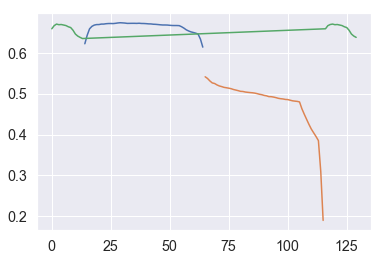

In [240]:
#sns.lineplot(x=results_df.Test_score_cv, hue="Algorithm", lw=1, data=results_df)
#ax = sns.lineplot(y = 'Test_score_cv',data = results_df)
#sns.lineplot(x = results_df.Test_score_cv,data = results_df)
#plt.plot(results_df[results_df.Algorithm == 'SVC_poly']['Test_score_cv'])

- SVC Kernel Sigmoid and RBF

In [ ]:
kernel = ['rbf','sigmoid']
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.4, 0.5,  0.8, 1.0, 2.0, 5.0, 10.0]

for kern in tqdm(kernels):
    for c in tqdm(C_values):
        f_el = "SVC_" + kern
        s_el,t_el = classify_and_score(SVC(kernel=kern,gamma='scale',C=c,random_state=seed,class_weight = 'balanced'), 
                                       vectorised_train_documents, vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " Kernel = " + kern

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score_cv':t_el, 'parameters':f0_el},ignore_index=True)

In [113]:
#drop svc results
#results_df = results_df[results_df.Algorithm !='LinearSVC']

In [ ]:
SGDClassifier(loss = 'hinge', penalty = 'elasticnet',
              alpha = 0.01, l1_ratio = 0.15,
              max_iter = 6, tol = 1e-3,
              n_jobs = -1, random_state = seed,
              learning_rate = 'optimal', #adaptive?
              class_weight = 'balanced'
             )
SVC 

# compare hinge loss == linear SVM
# compare other different kernels

GaussianNB не использовался, т.к. на вход этому алгоритму требуется dense, а не sparce-матрица.
При выполнении преобразования todense()/toarray() потребление памяти существенно возросло и привело к тому, что массив не помещяется в память.

In [ ]:
"""clf = GaussianNB()
clf.fit(vectorised_train_documents.toarray(), y_train)
pred = clf.predict(vectorised_test_documents.toarray())
f1_score(y_test, pred, average='micro')""";